https://www.kaggle.com/harsh1kumar/santander-trxn-pred-lightgbm/

https://www.kaggle.com/harsh1kumar/santander-trxn-pred-lightgbm/

https://sefiks.com/2018/10/13/a-gentle-introduction-to-lightgbm-for-applied-machine-learning/

In [270]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, fbeta_score

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [255]:
def plot_confusion_matrix(
    cm,
    target_names = ['Negative', 'Positive'],
    title        = 'Confusion matrix',
    cmap         = None,
    normalize    = False,
    figsize      = (4, 4)
):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
def lgbm_cv(train, target, cv_params):
    params = {
        'train_set': lgb.Dataset(train, label=target), 
        **cv_params
    }
    return lgb.cv(**params)

def lgbm_train(train_set, val_set, model_params):
    params = {
        'train_set': lgb.Dataset(train_set[0], label=train_set[1]),
        'valid_sets': [lgb.Dataset(val_set[0], label=val_set[1])], 
        **model_params
    }
    return lgb.train(**params)

def plot_lgbm_features_importance(model, figsize = (6,4), max_num_features=5):
    plt.rcParams["figure.figsize"] = figsize
    ax = lgb.plot_importance(model, max_num_features=5)
    plt.show()

def plot_lgbm_tree(model, figsize = (10,10)):
    plt.rcParams["figure.figsize"] = (10,10)
    lgb.plot_tree(model)
    plt.show()

In [5]:
dataset = pd.read_csv('../dataset/paquete_premium_202009.csv')

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235354 entries, 0 to 235353
Columns: 158 entries, numero_de_cliente to clase_ternaria
dtypes: float64(87), int64(70), object(1)
memory usage: 283.7+ MB


In [7]:
categorical_features = [
    'active_quarter',
    'cliente_vip',
    'internet',
    'tpaquete3',
    'tpaquete4',
    'tcuentas',
    'ccaja_seguridad',
    'thomebanking',
    'tmobile_app',
    'Master_delinquency',
    'Master_status',
    'Visa_delinquency',
    'Visa_status'
] 

In [8]:
target = 'clase_ternaria'
excluded_columns = [target, 'numero_de_cliente', 'foto_mes']

In [9]:
dataset['target'] = dataset[target].apply(lambda value: 0 if 'CONTINUA' == value else 1)
dataset.target.value_counts()

0    233894
1      1460
Name: target, dtype: int64

In [10]:
dataset.groupby(['target', target]).size()

target  clase_ternaria
0       CONTINUA          233894
1       BAJA+1               685
        BAJA+2               775
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

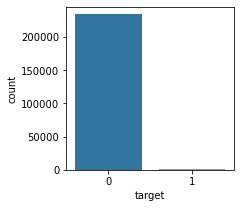

In [11]:
rcParams['figure.figsize'] = (3, 3)
sns.countplot(dataset.target)

In [12]:
dataset = dataset.drop(excluded_columns, axis=1)

In [13]:
# dataset.dtypes.to_dict() 

In [14]:
feature_columns = list(set(dataset.columns) - set(excluded_columns) - set(['target']))

In [15]:
X = dataset.loc[:, feature_columns]
y = dataset.loc[:,['target']]

In [16]:
target in X.columns

False

In [17]:
'target' in X.columns

False

In [365]:
hyper_params = {
    'deterministic': True,
    'num_leaves': 10,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'learning_rate': 0.01,
    'num_boost_round': 200,
    'verbosity': -1
}

cv_params = {
    'params': hyper_params,

    'stratified': True,
    'nfold': 10,
    'shuffle': True,
    'metrics': ['binary_logloss'],
    'seed': 0,
    'early_stopping_rounds': 100,
    'verbose_eval': False
}

cv_result = lgbm_cv(X, y, cv_params)
cv_result

{'binary_logloss-mean': [0.034605894482573264],
 'binary_logloss-stdv': [0.00013290096503097506]}

f1.5score: 16.135458167330675%


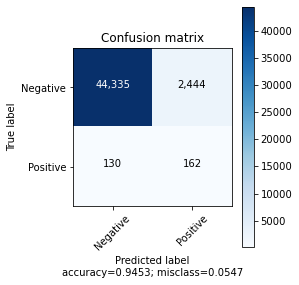

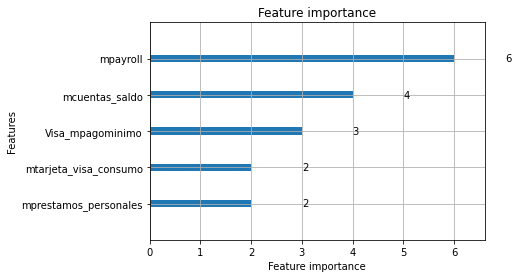

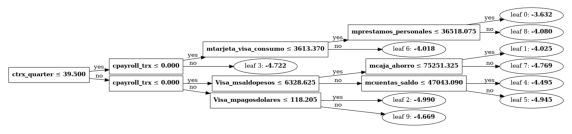

0    226034
1     12952
Name: Predicted, dtype: int64
0    224594
1     14392
Name: Predicted, dtype: int64


In [398]:
model_params = {
    'params':  {
        'deterministic': True,
        'num_leaves': 10,
        'objective': 'binary',
        'is_unbalance': 'true',
        'metric': 'binary_logloss',
        'learning_rate': 0.01,
        'num_boost_round': 5,
        'verbosity': -1
    },
    'categorical_feature': categorical_features,
    'verbose_eval': False
}

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

model = lgbm_train(
    train_set    = (X_train, y_train),
    val_set      = (X_valid, y_valid),
    model_params = model_params 
)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

threshold = 0.063
y_train_pred = (y_train_pred >= threshold).astype(int)
y_valid_pred = (y_valid_pred >= threshold).astype(int)

beta=1.5
print(f'f{beta}score: {fbeta_score(y_valid, y_valid_pred, beta=beta)*100}%')
plot_confusion_matrix(cm=confusion_matrix(y_valid, y_valid_pred))
plot_lgbm_features_importance(model)
plot_lgbm_tree(model)




test_set = pd.read_csv('../dataset/paquete_premium_202011.csv')
X_test   = test_set[X.columns]

y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred >= threshold).astype(int)

result = pd.DataFrame()
result['numero_de_cliente'] = test_set['numero_de_cliente'].astype(int)
result['Predicted']         = y_test_pred

print(result['Predicted'].value_counts())
result.to_csv('result.csv', index=False) 

best_result = pd.read_csv('../src/K101_001.csv')
print(best_result['Predicted'].value_counts())